# Example usage of TVModels package

<hr style="height:3px;border:none;color:#333;background-color:#333;" />

## Application for simulated time-varying model

In [1]:
using Pkg
Pkg.activate(".")

using TVModels
using Plots

  Activating project at `/mnt/c/Files/study/semestr9/Julia for Optimization and Learning/julia/TVModels/example`


Let's simulate the series with predefined coefficients' evolution 

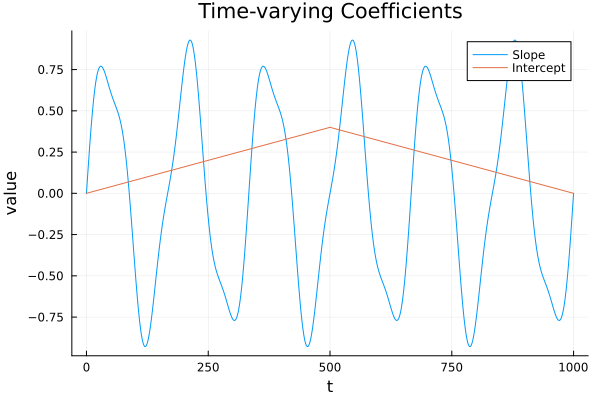

In [4]:
function beta_wiggle_sine(t::Float64; amp::Real=0.8, drift::Real=0.0, freq::Real=6.0)
    return drift .+ amp .* sin.(2π .* freq .* t) .+ 0.15 .* sin.(2π .* (freq * 2.5) .* t)
end

function moving_intercept(t::Float64)
    if t < 1/2
        return 0.8 * t
    else
        return 0.4 - 0.8 * (t - 1/2)
    end
end

t = 0:1000
plot(t, beta_wiggle_sine.(t/1000), label="Slope")
plot!(t, moving_intercept.(t/1000), label="Intercept")
xlabel!("t")
ylabel!("value")
title!("Time-varying Coefficients")

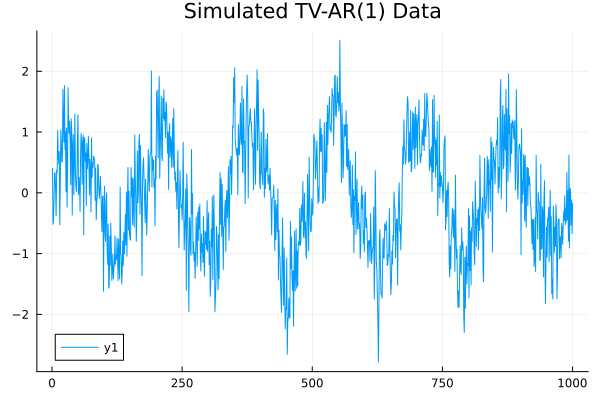

In [9]:
y = simulate_tv_ar(1000, [t->beta_wiggle_sine(t), t->moving_intercept(t)]; σ=0.5, seed = 123)
plot(y, title="Simulated TV-AR(1) Data")

Let's first optimize hyperparameters

In [ ]:
T_train = 200
T_test = length(y) - T_train

kernel_dict = Dict(
    :epanechnikov => epanechnikov_kernel,
    :cosine => cosine_kernel,
    :silverman => silverman_kernel,
    :gaussian => gaussian_kernel
)

bandwidths = [0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 1.0]
Hs = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

best_kernel, forecasts_kernel = optimize_kernel_ar(y, 1; T_train=T_train, kernel_dict=kernel_dict, bandwidths=bandwidths, return_forecasts=true)
best_lowess, forecasts_lowess = optimize_lowess_ar(y, 1; T_train=T_train, kernel_dict=kernel_dict, bandwidths=bandwidths, return_forecasts=true)
best_qbll, forecasts_qbll = optimize_QBLL_ar(y, 1; T_train=T_train, kernel_dict=kernel_dict, bandwidths=Hs, return_forecasts=true)

In [34]:
best_kernel

(kernel = :silverman, h_bw = 0.03, criterion = 0.3310011096051648)

In [35]:
best_lowess

(kernel = :silverman, h_bw = 0.03, criterion = 0.334287418706268)

In [36]:
best_qbll

(kernel = :epanechnikov, h_bw = 20, criterion = 0.32061000716541066)

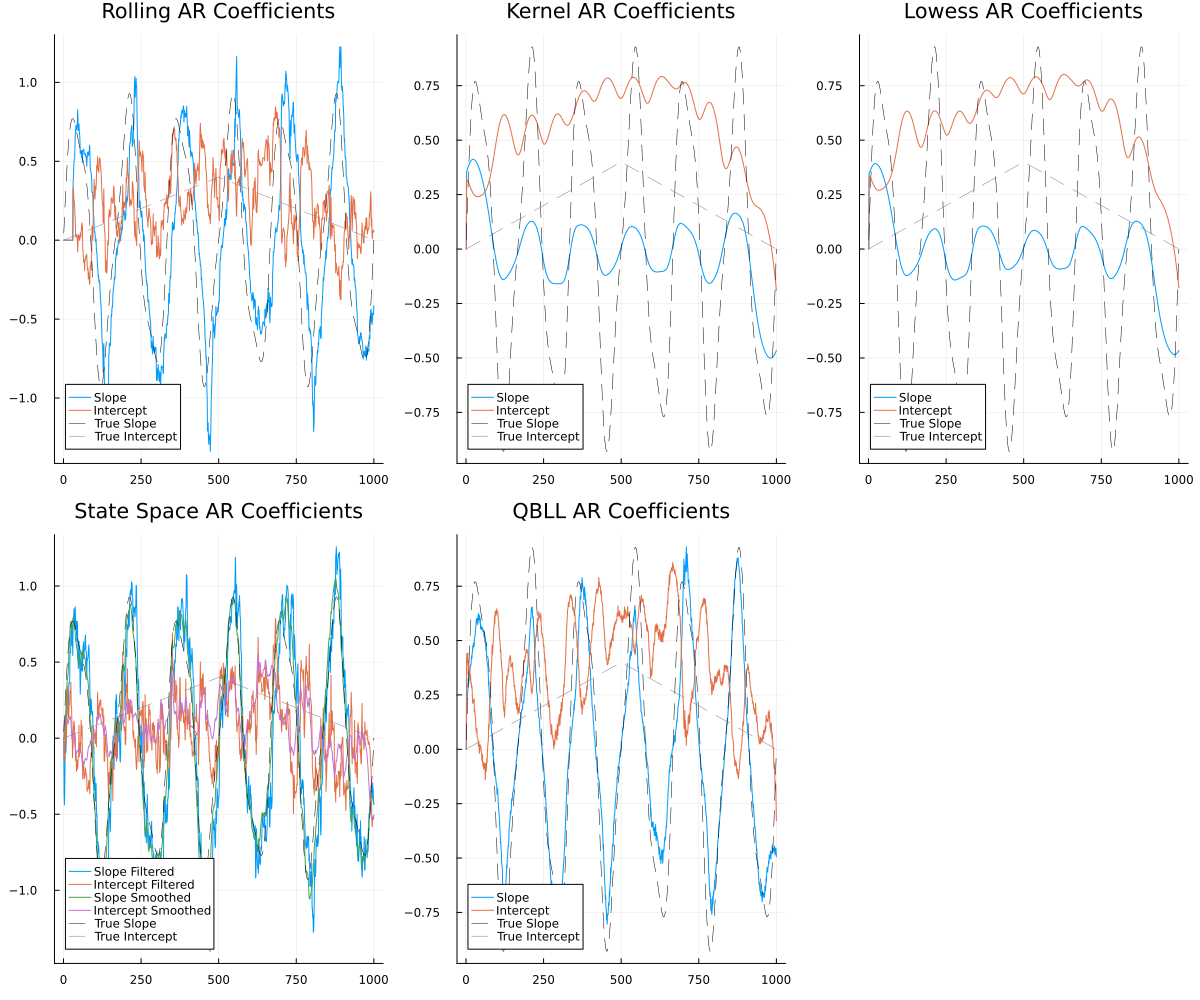

In [63]:
betas_rolling = rolling_ar(y, 1, 30; expanding=false)
betas_kernel = kernel_ar(y, 1, 0.03; kernel=silverman_kernel)
betas_lowess = lowess_ar(y, 1, 0.03, 3; kernel=silverman_kernel)
betas_state, _, betas_state_smooth, _  = state_ar(y, 1; sigma_eps = 0.5, Q = 0.01, β0=[0.0, 0.0], P0=1.0, smooth=true)
betas_qbll = QBLL_ar(y, 1, 1000, 30)

# All methods return T - p rows, so pad consistently
betas_rolling = vcat(zeros(30, 2), betas_rolling)
betas_kernel = vcat(zeros(1, 2), betas_kernel)
betas_lowess = vcat(zeros(1, 2), betas_lowess)
betas_state = vcat(zeros(1, 2), betas_state)
betas_state_smooth = vcat(zeros(1, 2), betas_state_smooth)
betas_qbll = vcat(zeros(1, 2), betas_qbll)

true_slope = [beta_wiggle_sine(t/1000) for t in 1:1000]
true_intercept = [moving_intercept(t/1000) for t in 1:1000]

p_rolling = plot(betas_rolling, title="Rolling AR Coefficients", label=["Slope" "Intercept"])
plot!(p_rolling, true_slope, label="True Slope", linestyle=:dash, color=:black, linewidth=0.5)
plot!(p_rolling, true_intercept, label="True Intercept", linestyle=:dash, color=:gray, linewidth=0.5)

p_kernel = plot(betas_kernel, title="Kernel AR Coefficients", label=["Slope" "Intercept"])
plot!(p_kernel, true_slope, label="True Slope", linestyle=:dash, color=:black, linewidth=0.5)
plot!(p_kernel, true_intercept, label="True Intercept", linestyle=:dash, color=:gray, linewidth=0.5)

p_lowess = plot(betas_lowess, title="Lowess AR Coefficients", label=["Slope" "Intercept"])
plot!(p_lowess, true_slope, label="True Slope", linestyle=:dash, color=:black, linewidth=0.5)
plot!(p_lowess, true_intercept, label="True Intercept", linestyle=:dash, color=:gray, linewidth=0.5)

p_state = plot(hcat(betas_state, betas_state_smooth), title="State Space AR Coefficients", label=["Slope Filtered" "Intercept Filtered" "Slope Smoothed" "Intercept Smoothed"])
plot!(p_state, true_slope, label="True Slope", linestyle=:dash, color=:black, linewidth=0.5)
plot!(p_state, true_intercept, label="True Intercept", linestyle=:dash, color=:gray, linewidth=0.5)

p_qbll = plot(betas_qbll, title="QBLL AR Coefficients", label=["Slope" "Intercept"])
plot!(p_qbll, true_slope, label="True Slope", linestyle=:dash, color=:black, linewidth=0.5)
plot!(p_qbll, true_intercept, label="True Intercept", linestyle=:dash, color=:gray, linewidth=0.5)

plot(p_rolling, p_kernel, p_lowess, p_state, p_qbll, layout=(2,3), size=(1200,1000))

In [70]:
# Calculate out-of-sample forecasts for rolling and state space methods
y_rolling = fill(NaN, T_test)
y_state = fill(NaN, T_test)

for (j, t) in enumerate((T_train + 1):length(y))
    # history up to t-1 only
    y_hist = y[1:(t-1)]
    betas_roll = rolling_ar(y_hist, 1, 30; expanding=false)
    betas_state, _  = state_ar(y_hist, 1; sigma_eps = 0.5, Q = 0.01, β0=[0.0, 0.0], P0=1.0, smooth=false)

    y_rolling[j] = forecast_regression(y_hist[end:end], betas_roll[end, :])
    y_state[j] = forecast_regression(y_hist[end:end], betas_state[end, :])
end

Let's plot the forecasts

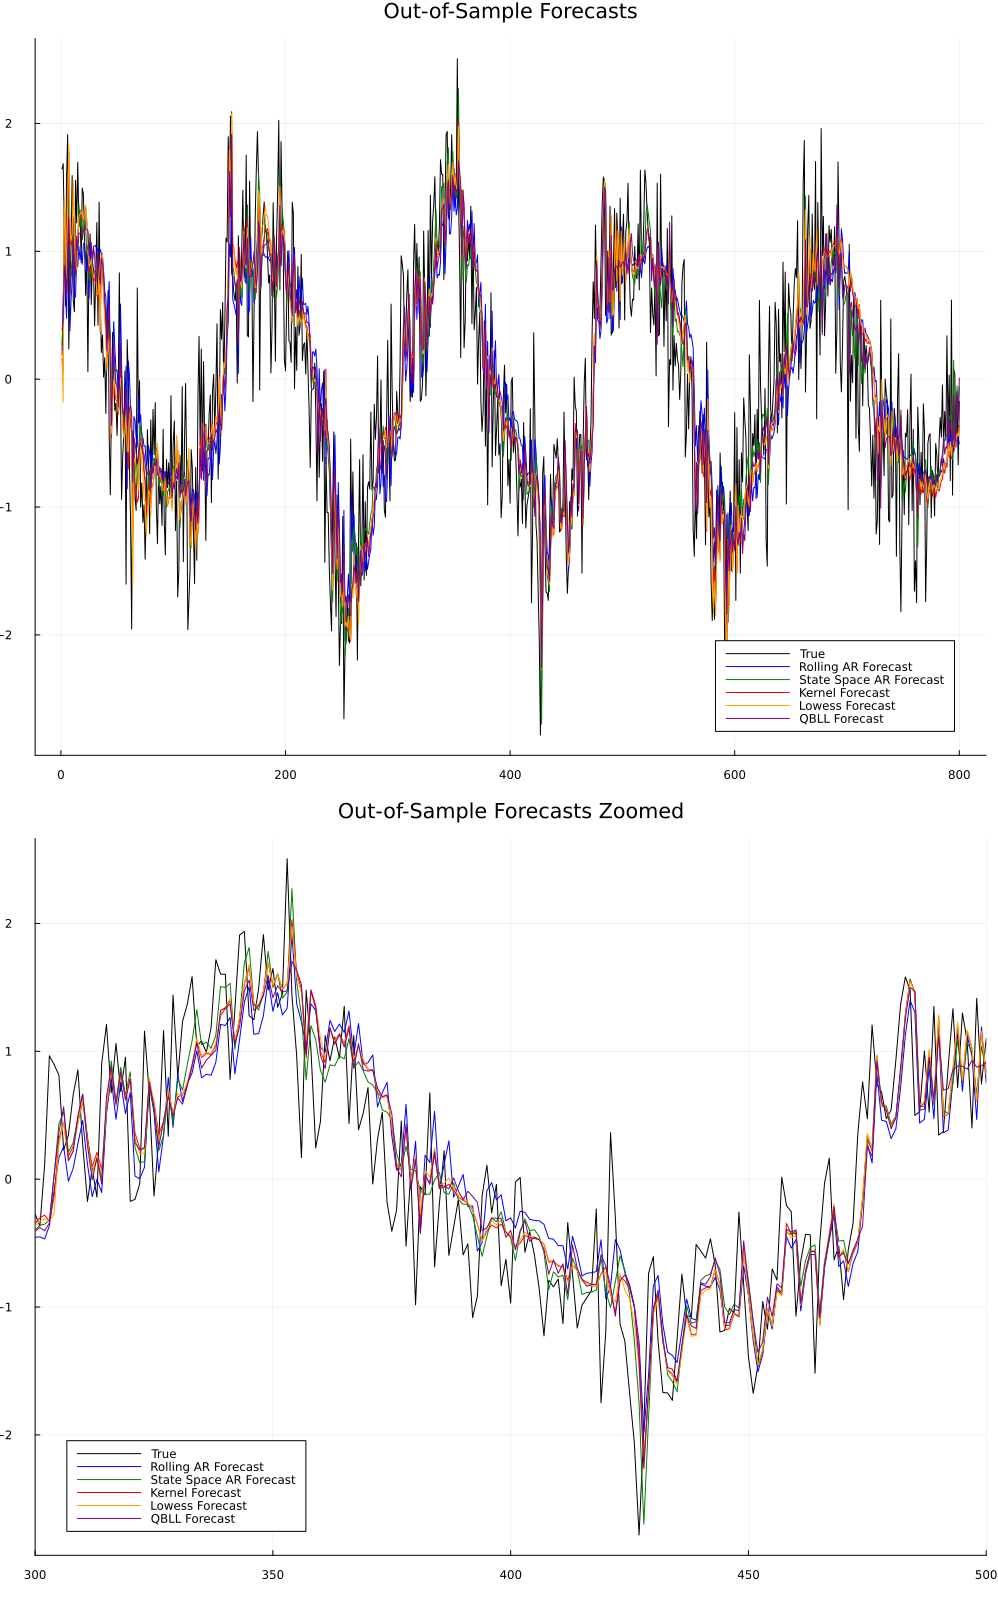

In [94]:
p1 = plot(y[T_train+1:end], label="True", title="Out-of-Sample Forecasts", size=(1000,800), color=:black)
plot!(y_rolling, label="Rolling AR Forecast", color=:blue)
plot!(y_state, label="State Space AR Forecast", color=:green)
plot!(forecasts_kernel[1], label="Kernel Forecast", color=:red)
plot!(forecasts_lowess[1], label="Lowess Forecast", color=:orange)
plot!(forecasts_qbll[1], label="QBLL Forecast", color=:purple)

p2 =plot(y[T_train+1:end], label="True", title="Out-of-Sample Forecasts Zoomed", size=(1000,800), xlims=(300, 500), color=:black)
plot!(y_rolling, label="Rolling AR Forecast", color=:blue)
plot!(y_state, label="State Space AR Forecast", color=:green)
plot!(forecasts_kernel[1], label="Kernel Forecast", color=:red)
plot!(forecasts_lowess[1], label="Lowess Forecast", color=:orange)
plot!(forecasts_qbll[1], label="QBLL Forecast", color=:purple)

plot(p1, p2, layout=(2,1), size=(1000,1600))

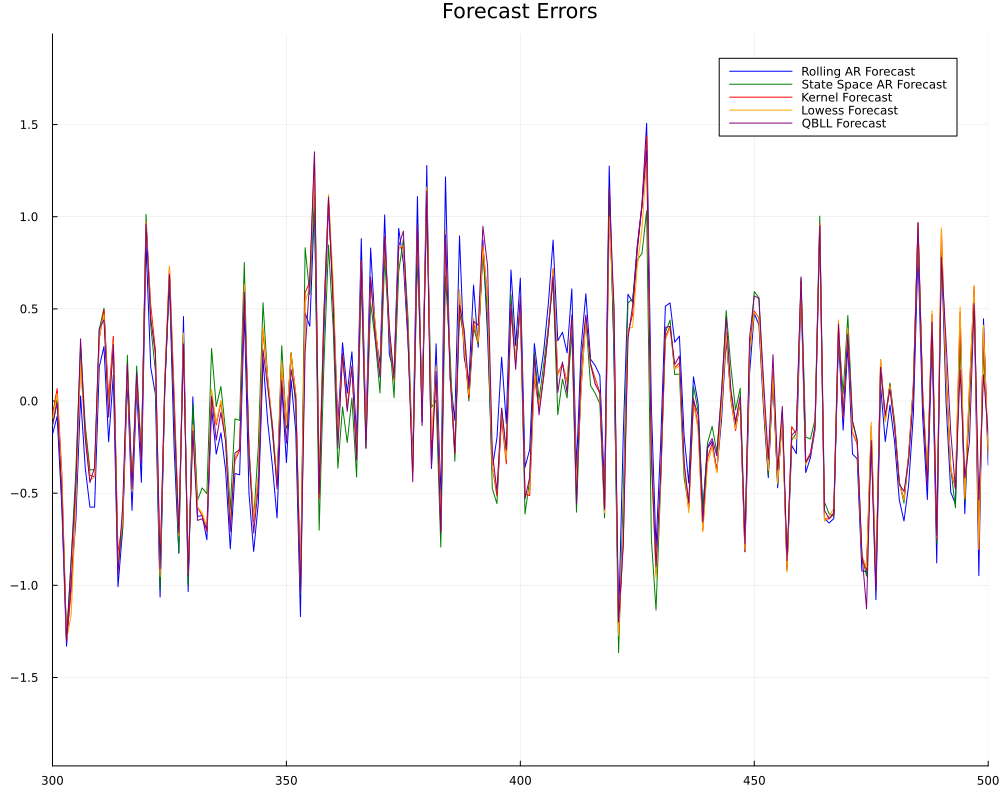

In [97]:
plot(y_rolling - y[T_train+1:end], label="Rolling AR Forecast", color=:blue, title="Forecast Errors", size=(1000,800), xlims=(300, 500))
plot!(y_state - y[T_train+1:end], label="State Space AR Forecast", color=:green)
plot!(forecasts_kernel[1] - y[T_train+1:end], label="Kernel Forecast", color=:red)
plot!(forecasts_lowess[1] - y[T_train+1:end], label="Lowess Forecast", color=:orange)
plot!(forecasts_qbll[1] - y[T_train+1:end], label="QBLL Forecast", color=:purple)

In [118]:
using Statistics

# Calculate metrics for each model
models = Dict(
    "Rolling AR" => y_rolling,
    "State Space AR" => y_state,
    "Kernel" => forecasts_kernel[1],
    "Lowess" => forecasts_lowess[1],
    "QBLL" => forecasts_qbll[1]
)

y_true = y[T_train+1:end]

results = []
for (name, forecast) in models
    mse = mean((forecast .- y_true).^2)
    rmse = sqrt(mse)
    mae = mean(abs.(forecast .- y_true))
    mape = mean(abs.(forecast .- y_true) ./ abs.(y_true)) * 100
    push!(results, (Model=name, MSE=mse, RMSE=rmse, MAE=mae, MAPE=mape))
end

using DataFrames
df_metrics = DataFrame(results)

5×5 DataFrame
 Row │ Model           MSE       RMSE      MAE       MAPE    
     │ String          Float64   Float64   Float64   Float64 
─────┼───────────────────────────────────────────────────────
   1 │ Rolling AR      0.3571    0.597578  0.485774  256.999
   2 │ QBLL            0.321468  0.566982  0.458489  261.44
   3 │ Lowess          0.334287  0.578176  0.465367  281.78
   4 │ State Space AR  0.311838  0.558424  0.447011  259.913
   5 │ Kernel          0.331001  0.575327  0.46343   275.585

State-space model seems to be the best!

<hr style="height:3px;border:none;color:#333;background-color:#333;" />

## Application for the real variable

We will regress next-month S\&P500 returns on 11 economic monthly variables.

Data are from 01/1945 to 12/2024.

In [ ]:
using CSV

data = CSV.read("Data2024.xlsx - Monthly.csv", DataFrame) 

data = data[data[!, :yyyymm] .>= 194501, :]

data = data[:, [:yyyymm, :ret, :Rfree, 
                :d_y, :e_p, :d_e, :b_m,
                :ntis, :tbl, :tms, :dfy, 
                :dfr, :infl, :svar,]]

data[!, :excess_ret] = log.(1 .+ data[!, :ret]) .- log.(1 .+ data[!, :Rfree])

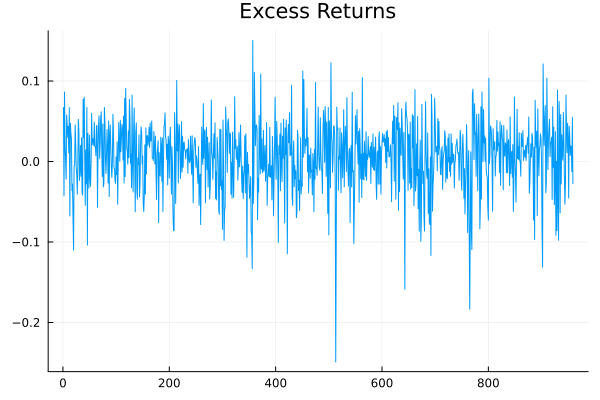

In [19]:
y = data[2:end, :excess_ret]
X = Matrix(data[1:end-1, Not([:yyyymm, :ret, :Rfree, :excess_ret])])
X = convert(Matrix{Float64}, X)

plot(y, title="Excess Returns", legend=false)

In [ ]:
T_train = 200
T_test = length(y) - T_train

kernel_dict = Dict(
    :epanechnikov => epanechnikov_kernel,
    :cosine => cosine_kernel,
    :silverman => silverman_kernel,
    :gaussian => gaussian_kernel
)

bandwidths = [0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 1.0]

best_kernel, forecasts_kernel = optimize_kernel_regression(y, X; T_train=T_train, kernel_dict=kernel_dict, bandwidths=bandwidths, return_forecasts=true)
best_lowess, forecasts_lowess = optimize_lowess_regression(y, X; T_train=T_train, kernel_dict=kernel_dict, bandwidths=bandwidths, return_forecasts=true)

kernel_dict = Dict(
    :epanechnikov => epanechnikov_kernel,
    :silverman => silverman_kernel,
    :gaussian => gaussian_kernel
)
Hs = [5, 10, 20, 50, 100]

best_qbll, forecasts_qbll = optimize_QBLL_regression(y, X; T_train=T_train, kernel_dict=kernel_dict, bandwidths=Hs, return_forecasts=true)


In [52]:
best_kernel

(kernel = :gaussian, h_bw = 1.0, criterion = 0.0023025778639957518)

In [53]:
best_lowess

(kernel = :gaussian, h_bw = 0.5, criterion = 0.002273580072624853)

In [55]:
best_qbll

(kernel = :gaussian, h_bw = 50, criterion = 0.002057415513083532)

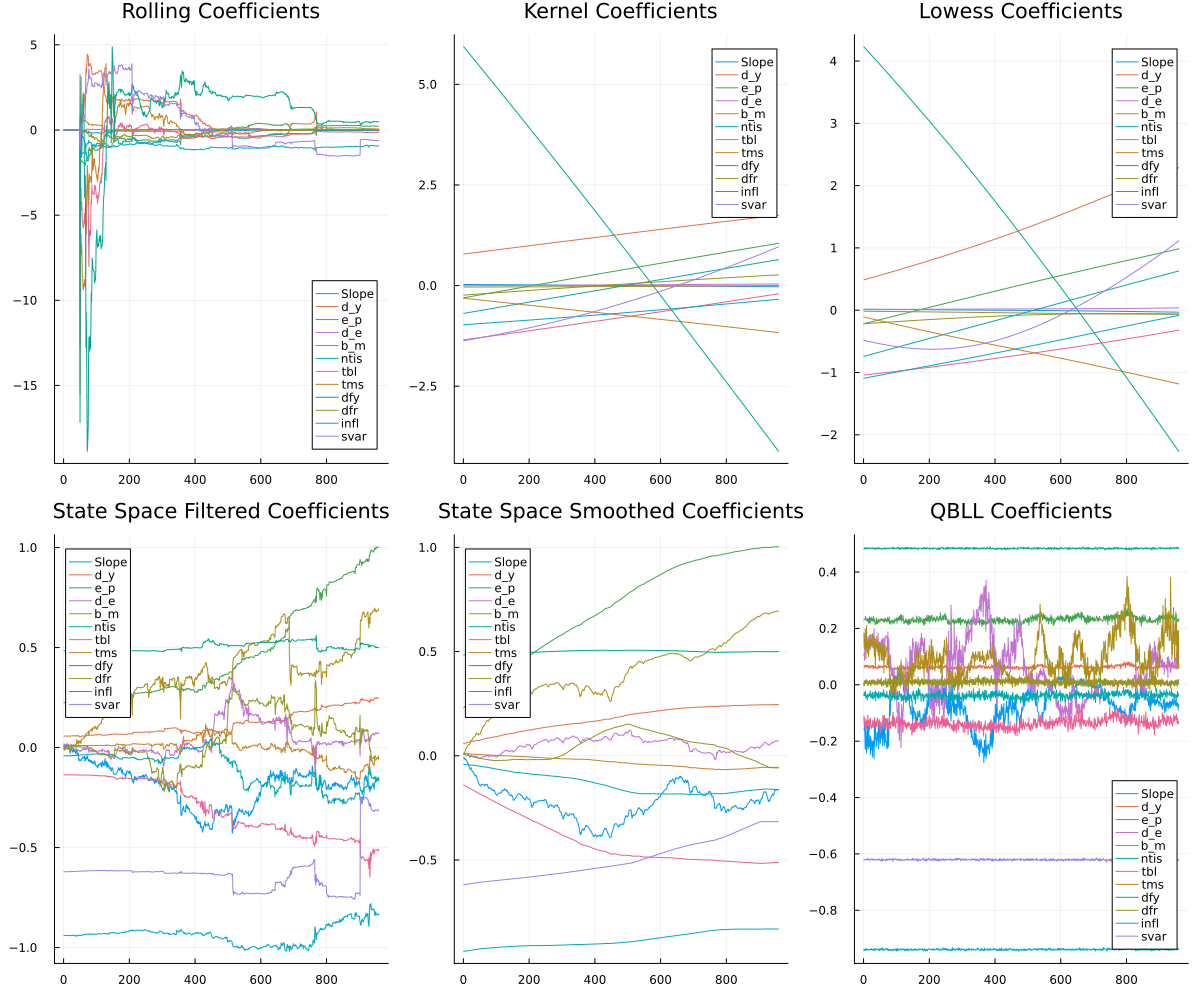

In [68]:
window = 50
betas_rolling = rolling_regression(y, X, window; expanding=true)
betas_kernel = kernel_regression(y, X, 1.0; kernel=silverman_kernel)
betas_lowess = lowess_regression(y, X, 0.5, 3; kernel=silverman_kernel)
OLS_betas = hcat(ones(size(X, 1)), X) \ y
betas_state, _, betas_state_smooth, _  = state_regression(y, X; sigma_eps = 0.5, Q = 0.03, β0=OLS_betas, P0=0.1, smooth=true)
betas_qbll = QBLL_regression(y, X, 1000, 50)

# All methods return T - p rows, so pad consistently
betas_rolling = vcat(zeros(window-1, size(betas_rolling, 2)), betas_rolling)
# betas_kernel = vcat(zeros(1, 2), betas_kernel)
# betas_lowess = vcat(zeros(1, 2), betas_lowess)
# betas_state = vcat(zeros(1, 2), betas_state)
# betas_state_smooth = vcat(zeros(1, 2), betas_state_smooth)
# betas_qbll = vcat(zeros(1, 2), betas_qbll)

p_rolling = plot(betas_rolling, title="Rolling Coefficients", label=["Slope" "d_y" "e_p" "d_e" "b_m" "ntis" "tbl" "tms" "dfy" "dfr" "infl" "svar"])
p_kernel = plot(betas_kernel, title="Kernel Coefficients", label=["Slope" "d_y" "e_p" "d_e" "b_m" "ntis" "tbl" "tms" "dfy" "dfr" "infl" "svar"])
p_lowess = plot(betas_lowess, title="Lowess Coefficients", label=["Slope" "d_y" "e_p" "d_e" "b_m" "ntis" "tbl" "tms" "dfy" "dfr" "infl" "svar"])
p_state_filt = plot(betas_state, title="State Space Filtered Coefficients", label=["Slope" "d_y" "e_p" "d_e" "b_m" "ntis" "tbl" "tms" "dfy" "dfr" "infl" "svar"])
p_state_smooth = plot(betas_state_smooth, title="State Space Smoothed Coefficients", label=["Slope" "d_y" "e_p" "d_e" "b_m" "ntis" "tbl" "tms" "dfy" "dfr" "infl" "svar"])
p_qbll = plot(betas_qbll, title="QBLL Coefficients", label=["Slope" "d_y" "e_p" "d_e" "b_m" "ntis" "tbl" "tms" "dfy" "dfr" "infl" "svar"])

plot(p_rolling, p_kernel, p_lowess, p_state_filt, p_state_smooth, p_qbll, layout=(2,3), size=(1200,1000))

In [73]:
# Calculate out-of-sample forecasts for rolling and state space methods
y_rolling = fill(NaN, T_test)
y_state = fill(NaN, T_test)

for (j, t) in enumerate((T_train + 1):length(y))
    # history up to t-1 only
    y_hist = y[1:(t-1)]
    X_hist = X[1:(t-1), :]
    betas_roll = rolling_regression(y_hist, X_hist, 50; expanding=true)
    betas_state, _  = state_regression(y_hist, X_hist; sigma_eps = 0.5, Q = 0.03, β0=OLS_betas, P0=0.1, smooth=false)

    y_rolling[j] = forecast_regression(X_hist[end, :], betas_roll[end, :])
    y_state[j] = forecast_regression(X_hist[end, :], betas_state[end, :])
end

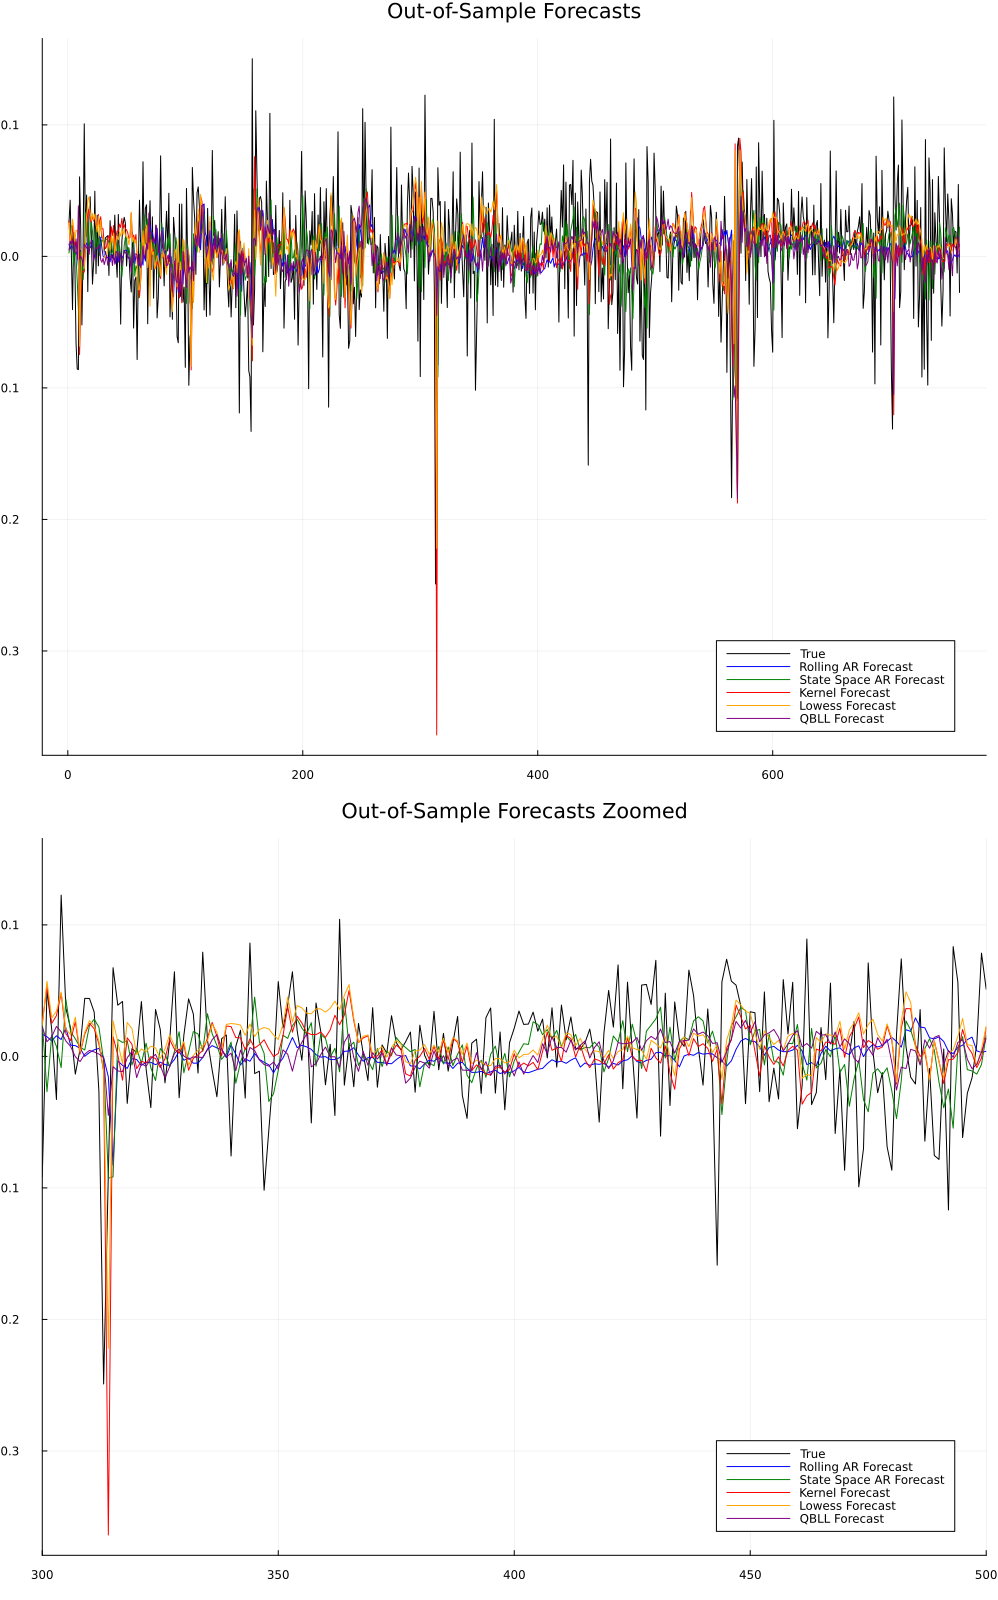

In [74]:
p1 = plot(y[T_train+1:end], label="True", title="Out-of-Sample Forecasts", size=(1000,800), color=:black)
plot!(y_rolling, label="Rolling AR Forecast", color=:blue)
plot!(y_state, label="State Space AR Forecast", color=:green)
plot!(forecasts_kernel[1], label="Kernel Forecast", color=:red)
plot!(forecasts_lowess[1], label="Lowess Forecast", color=:orange)
plot!(forecasts_qbll[1], label="QBLL Forecast", color=:purple)

p2 =plot(y[T_train+1:end], label="True", title="Out-of-Sample Forecasts Zoomed", size=(1000,800), xlims=(300, 500), color=:black)
plot!(y_rolling, label="Rolling AR Forecast", color=:blue)
plot!(y_state, label="State Space AR Forecast", color=:green)
plot!(forecasts_kernel[1], label="Kernel Forecast", color=:red)
plot!(forecasts_lowess[1], label="Lowess Forecast", color=:orange)
plot!(forecasts_qbll[1], label="QBLL Forecast", color=:purple)

plot(p1, p2, layout=(2,1), size=(1000,1600))

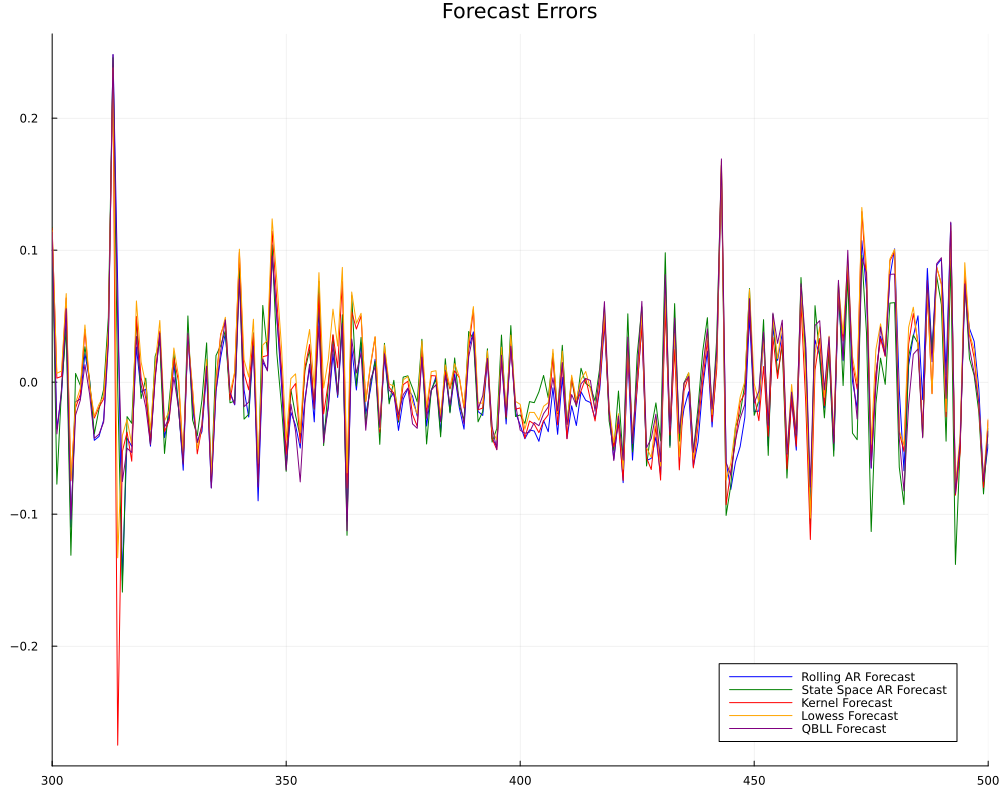

In [75]:
plot(y_rolling - y[T_train+1:end], label="Rolling AR Forecast", color=:blue, title="Forecast Errors", size=(1000,800), xlims=(300, 500))
plot!(y_state - y[T_train+1:end], label="State Space AR Forecast", color=:green)
plot!(forecasts_kernel[1] - y[T_train+1:end], label="Kernel Forecast", color=:red)
plot!(forecasts_lowess[1] - y[T_train+1:end], label="Lowess Forecast", color=:orange)
plot!(forecasts_qbll[1] - y[T_train+1:end], label="QBLL Forecast", color=:purple)

In [ ]:
forecasts_random_walk = fill(NaN, T_test)
for j in 1:T_test
    forecasts_random_walk[j] = y[T_train + j - 1]
end

In [80]:
# Calculate metrics for each model
models = Dict(
    "Rolling AR" => y_rolling,
    "State Space AR" => y_state,
    "Kernel" => forecasts_kernel[1],
    "Lowess" => forecasts_lowess[1],
    "QBLL" => forecasts_qbll[1],
    "Random Walk" => forecasts_random_walk
)

y_true = y[T_train+1:end]

results = []
for (name, forecast) in models
    mse = mean((forecast .- y_true).^2)
    rmse = sqrt(mse)
    mae = mean(abs.(forecast .- y_true))
    mape = mean(abs.(forecast .- y_true) ./ abs.(y_true)) * 100
    push!(results, (Model=name, MSE=mse, RMSE=rmse, MAE=mae, MAPE=mape))
end

using DataFrames
df_metrics = DataFrame(results)

6×5 DataFrame
 Row │ Model           MSE         RMSE       MAE        MAPE    
     │ String          Float64     Float64    Float64    Float64 
─────┼───────────────────────────────────────────────────────────
   1 │ Rolling AR      0.00203964  0.0451624  0.033868   178.291
   2 │ Random Walk     0.0036859   0.0607116  0.0463528  546.046
   3 │ QBLL            0.00208995  0.0457159  0.0337347  158.957
   4 │ Lowess          0.00227358  0.0476821  0.0347581  199.502
   5 │ State Space AR  0.00223685  0.0472953  0.0352934  238.758
   6 │ Kernel          0.00230258  0.0479852  0.0345731  220.522